## Develop segmentation method 

In [2]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# import skimage.segmentation as segmentation
# import skimage.filters as filters
# import skimage.color as color

In [3]:
# Local imports
sys.path.insert(0, 'src')
import utils
from utils import read_json, read_lists, prepare_device
from utils import visualizations
from utils import segmentation_utils
from parse_config import ConfigParser
from data_loader import data_loaders
import model.model as module_arch

ModuleNotFoundError: No module named 'skimage'

In [6]:
image_path = 'data/cinic-10-imagenet/train/dog/n02114712_211.png'
image = utils.load_image(image_path)
split = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
class_name = os.path.basename(os.path.dirname(image_path))
file_name = os.path.basename(image_path).split(".")[0]
image_name = "{}-{}-{}".format(split, class_name, file_name)
print(image_name)
felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Choose felzenszwalb this time
method = 'felzenszwalb'
segmentation_params = felzenszwalb_params
segments = segmentation_utils.segment(
    image,
    method=method,
    kwargs=segmentation_params)

gaussian_modified_images = segmentation_utils.modify_segments(
    image,
    segments=segments,
    method='gaussian_noise',
    mean=0,
    std=0.1)

masked_modified_images = segmentation_utils.modify_segments(
    image=image,
    segments=segments,
    method='mask')

save_data = {
    "original_image": image,
    "segmentation_method": method,
    "segmentation_params": segmentation_params,
    "gaussian_modified_images": gaussian_modified_images,
    "masked_modified_images": masked_modified_images
}

save_path = os.path.join('temp', '{}.pth'.format(image_name))
torch.save(save_data, save_path)

train-dog-n02114712_211
KWargs: {'mean': 0, 'std': 0.1}
KWargs: {}


In [ ]:
# Define constants, paths
config_path = 'configs/debug/cinic10_imagenet_edit_knn_debug.json'

In [ ]:
# Load config file, models
config_json = read_json(config_path)
config = ConfigParser(config_json)


device, device_ids = prepare_device(config['n_gpu'])

In [164]:
# Load datasets
# data_loader_args = dict(config_dict["data_loader"]["args"])

In [6]:
# Load model
layernum = config.config['layernum']
model = config.init_obj('arch', module_arch, layernum=layernum)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [5]:
# plot bar graph

def bar_graph(data, 
              labels=None, 
              groups=None,
              title=None,
              ylabel=None,
              save_path=None):
    '''
    Given data, make a bar graph
    
    Arg(s):
        data : N x C np.array
            N : number of data points
            C : number of bar classes
        labels : list[str]
            C length list of labels for each bar
        groups : list[str]
            N list of group names
        title : str
            title for bar graph
        ylabel : str
            label for y-axis
        save_path : str
            if not None, the path to save bar graph to
    '''
    fig, ax = plt.subplots()
    assert len(data.shape) == 2, "Expected 2D data, received {}D data.".format(len(data.shape))
    n_groups, n_classes = data.shape
    
    # Parameters for bar graphs
    x_pos = np.arange(n_classes)
    width = 1 / n_groups 
    if labels is None:
        labels = ["" for i in range(n_classes)]
    if groups is None:
        groups = [i for i in range(n_groups)]
    
    mid_idx = n_groups // 2
    if n_groups % 2 == 0: # Even number of groups
        for group_idx, group_data in enumerate(data):
            if group_idx < mid_idx:
                ax.bar(x_pos - width * ((mid_idx - group_idx) * 2 - 1) / 2, 
                       group_data,
                       alpha=0.75,
                       ecolor='black',
                       capsize=10,
                       label=groups[group_idx],
                       width=width)
            else:
                ax.bar(x_pos + width * ((group_idx - mid_idx) * 2 + 1) / 2, 
                       group_data,
                       alpha=0.75,
                       ecolor='black',
                       capsize=10,
                       label=groups[group_idx],
                       width=width)
        
    else:  # Odd number of groups
        for group_idx, group_data in enumerate(data):
            if group_idx < mid_idx:
                ax.bar(x_pos - 1 / 2 + width * group_idx,
                    group_data,
                    alpha=0.75,
                    ecolor='black',
                    capsize=10,
                    label=groups[group_idx],
                    width=width)
            elif group_idx == mid_idx:
                ax.bar(x_pos - width / 2, 
                    group_data,
                    alpha=0.75,
                    ecolor='black',
                    capsize=10,
                    label=groups[group_idx],
                    width=width)
            else: 
                ax.bar(x_pos - width / 2 + (group_idx - mid_idx) * width,
                    group_data,
                    alpha=0.75,
                    ecolor='black',
                    capsize=10,
                    label=groups[group_idx],
                    width=width)
    
    # Set prettiness 
    ax.set_xticks(x_pos, labels)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    ax.legend()
    plt.tight_layout()

    # If save_path is not None, save graph
    if save_path is not None:
        if not os.path.isdir(os.path.dirname(save_path)):
            os.makdirs(os.path.dirname(save_path))
        plt.savefig(save_path)

    # Show figure
    plt.show()
    

def get_most_changed_idxs(data):
    '''
    Given data, return dictionary with indices of data that is 
        1. most changed overall
        2. most changed in predicted class

    Arg(s):
        data : N x C np.array or torch.tensor
            N is number of data points
            C is number of classes
            element at 0 is the original prediction
    
    Returns:
        dict[str] : int
    '''

    if torch.is_tensor(data):
        data = data.cpu().numpy()
    original_logits = data[0]
    modified_logits = data[1:]

    original_class_prediction = np.argmax(original_logits)
    original_class_logits = original_logits[original_class_prediction]
    # Determine which modified index has the most change in the predicted class
    modified_target_logits = modified_logits[:, original_class_prediction]
    delta_modified_target_logits = modified_target_logits - original_class_logits
    most_changed_target = np.argmax(delta_modified_target_logits)

    # Determine which modified index has most change in logits overall
    change_logits = np.abs(modified_logits - np.broadcast_to(original_logits, shape=modified_logits.shape))
    sum_change_logits = np.sum(change_logits, axis=1)
    most_changed_overall = np.argmax(sum_change_logits)

    return {"target": most_changed_target, "overall": most_changed_overall}


    

torch.Size([7, 10])
width: 0.14285714285714285


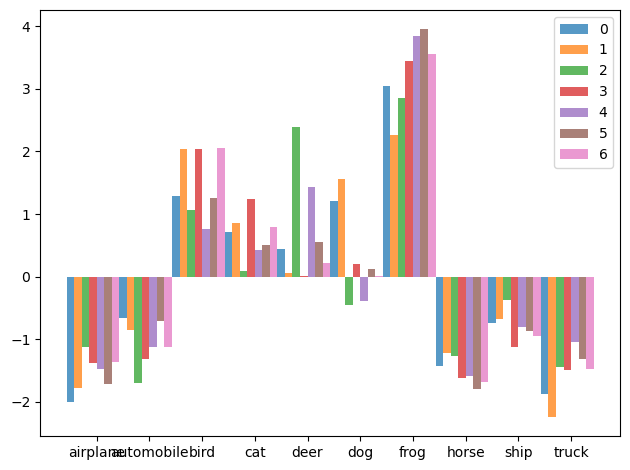

{'target': 4, 'overall': 1}


In [7]:
# load numbers from checkpoint
logits = torch.load('temp/gaussian_noise_mod_logits.pth', map_location=torch.device('cpu'))
classes = utils.read_lists('metadata/cinic-10/class_names.txt')
print(logits.shape)
bar_graph(logits, labels=classes)
# bar_graph(torch.unsqueeze(logits[0], dim=0))
indices = get_most_changed_idxs(logits)
print(indices)


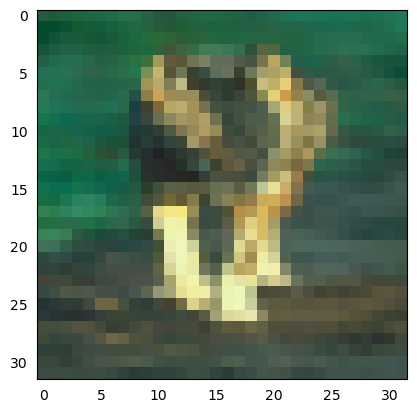

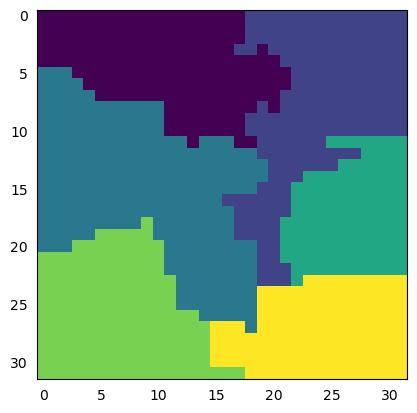

KWargs: {}
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


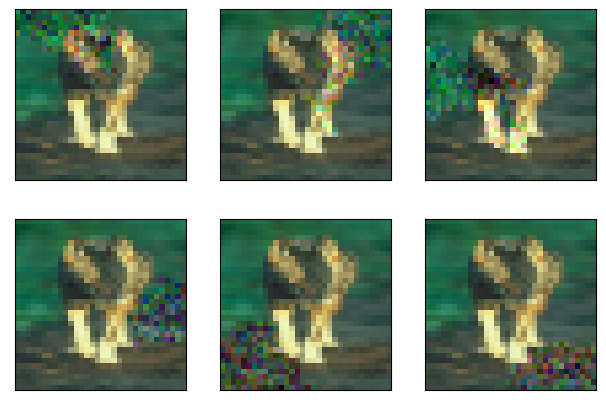

(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


In [173]:
# Get segmentation of image
image = utils.load_image('data/cinic-10-imagenet/train/dog/n02114712_211.png')
slic_params = {
    'n_segments': 10,
}
segments = segment(
    image,
    method='slic',
    params=slic_params)

visualizations.show_image(image)
visualizations.show_image(segments)
# modified_images = modify_segments(
#     image=image,
#     segments=segments,
#     method='mask')

# Modify each segment 1 by 1
modified_images = modify_segments(
    image=image,
    segments=segments,
    method='gaussian_noise')

modified_images_grid = visualizations.make_grid(modified_images, items_per_row=3)
visualizations.show_image_rows(modified_images_grid)
# Add original image to images list and stack
images = [image] + modified_images
images = torch.from_numpy(np.stack(images, axis=0))
images = images.type(torch.FloatTensor)
images = images.to(device)

# Convert model to evaluation mode
model.eval()
with torch.no_grad():
    logits = model(images)


In [2]:
# for image_logits in logits:
#     print(image_logits)
#     print(torch.argmax(image_logits))

original_pred = logits[0]
modified_preds = logits[1:]
logit_changes = []
for modified_pred in modified_preds:
    
    change = original_pred - modified_pred
    total_change = torch.sum(torch.abs(change))
    print(change, total_change)
    logit_changes.append(total_change)

bar_graph(logits)

NameError: name 'logits' is not defined

In [113]:
# # Function definitions

# def segment(image, method, params):
#     '''
#     Given an image and a segmentation method, and necessary keyword arguments, return segments

#     Arg(s):
#         image : C x H x W np.array   
#             Image to segment
#         method : str
#             type of segmentation method
#         params : dict
#             keyword arguments for specific segmentation method
            
#     Returns:
#         segments : H x W np.array
#             Each segment labeled by integer index
#     '''

#     # Assert image is in C x H x W shape
#     assert len(image.shape) == 3, "Image expected to have shape C x H x W"
#     assert image.shape[0] == 3, "Image expected to have 3 channels in dimension 0"
#     params['channel_axis'] = 0
    
#     if method == 'felzenszwalb':
#         segments = segmentation.felzenszwalb(
#             image,
#             **params)
#     elif method == 'quickshift':
#         segments = segmentation.quickshift(
#             image,
#             **params)
#     elif method == 'slic':
#         segments = segmentation.slic(
#             image,
#             **params)
    
#     elif method == 'watershed':
#         del params['channel_axis']
#         gradient = filters.sobel(color.rgb2gray(np.transpose(image, axes=[1, 2, 0])))
#         segments = segmentation.watershed(
#             gradient,
#             **params)
#     else:
#         raise ValueError("Segmentation method {} not supported.".format(method))
#     return segments

In [112]:
# Pedal to the metal!

image = utils.load_image('data/cinic-10-imagenet/train/dog/n02114712_211.png')

felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

methods = []
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))
# methods.append(('quickshift', {}))
methods.append(('quickshift', quickshift_params))
# methods.append(('felzenszwalb', {}))
methods.append(('felzenszwalb', felzenszwalb_params))

for method, params in methods:
    print("Method: {}, params: {}".format(method, params))
    labels = segment(
        image,
        method=method,
        params=params)
    uniques = np.unique(labels)
    print("{} generated {} unique segments".format(method, len(uniques)))
    print(uniques)
    

Method: slic, params: {'n_segments': 10}
slic generated 6 unique segments
[1 2 3 4 5 6]
Method: watershed, params: {'markers': 10, 'watershed_line': True}
watershed generated 10 unique segments
[0 1 2 3 4 5 6 7 8 9]
Method: quickshift, params: {'max_dist': 25, 'kernel_size': 3, 'sigma': 0.9}
quickshift generated 5 unique segments
[0 1 2 3 4]
Method: felzenszwalb, params: {'scale': 0.9, 'sigma': 0.25, 'min_size': 50}
felzenszwalb generated 6 unique segments
[0 1 2 3 4 5]


# Given an image and a segmentation, mask out each section and return

In [151]:
# def mask_out(image, mask):
#     '''
#     Given an image and binary mask, black out where mask is activated
    
#     Arg(s):
#         image : C x H x W np.array
#             original image
#         mask : C x H x W np.array (2D array broadcasted in C dimension)
#             mask
        
#     Returns:
#         image : C x H x W np.array
#             image with masked portion blacked out
#     '''
#     image = np.where(mask == 1, 0, image)
#     return image

# def gaussian_noise(image, mask, mean=0, std=0.1):
#     '''
#     Given an image and binary mask, apply Gaussian noise to masked region
    
#     Arg(s):
#         image : C x H x W np.array
#             original image
#         mask : C x H x W np.array (2D array broadcasted in C dimension)
#             mask
#         mean : float
#             mean for Gaussian distribution
#         std : float
#             standard deviation for Gaussian distribution
        
#     Returns:
#         image : C x H x W np.array
#             image with noise added to masked portion
#     '''
#     normal_distribution = np.random.normal(mean, std, size=image.shape)
#     image = np.where(mask == 1, image + normal_distribution, image)
#     return image

# def modify_segments(image,
#                     segments,
#                     method,
#                     **kwargs):
#     '''
#     Given an image, the segmentation, and modification, return list of images with each segment modified
    
#     Arg(s):
#         image : C x H x W np.array (np.float)
#             original image
#         segments : H x W np.array (np.int)
#             segmented image (e.g. output of utils.segmentation_utils.segment()
#         method : str
#             type of modification to perform
    
#     Returns:
#         modified_images : list[C x H x W np.array]
#             list of modified images, one per segment
#     '''
#     print("KWargs: {}".format(kwargs))
#     # Obtain number of segments
#     unique_segments = np.unique(segments)
#     n_segments = len(unique_segments)
#     broadcasted_segments = np.broadcast_to(segments, shape=(3, *segments.shape))
#     modified_images = []
    
#     # Determine modification method
#     if method == 'gaussian_noise':
#         modification_func = gaussian_noise
        
#     elif method == 'mask':
#         modification_func = mask_out
#         kwargs = {}
#     else:
#         raise ValueError("Modification method {} not supported".format(method))

#     # Modify each segment
#     for label in unique_segments:
#         label_mask = np.where(segments == label, 1, 0)

#         modified_image = modification_func(image, label_mask, **kwargs)
#         modified_images.append(modified_image)

        
#     return modified_images
        

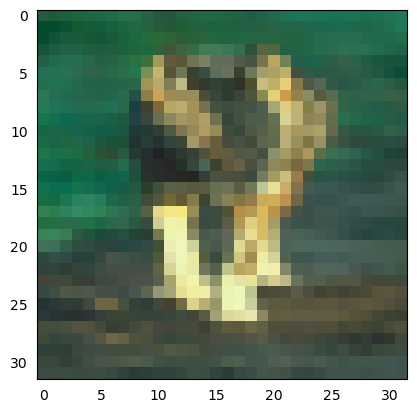

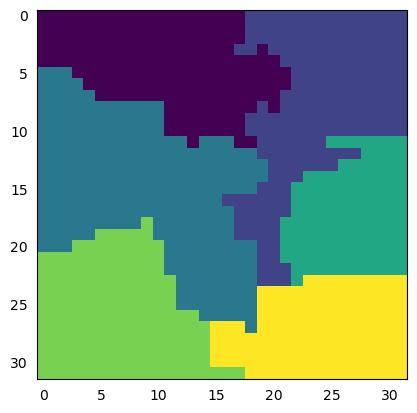

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KWargs: {}


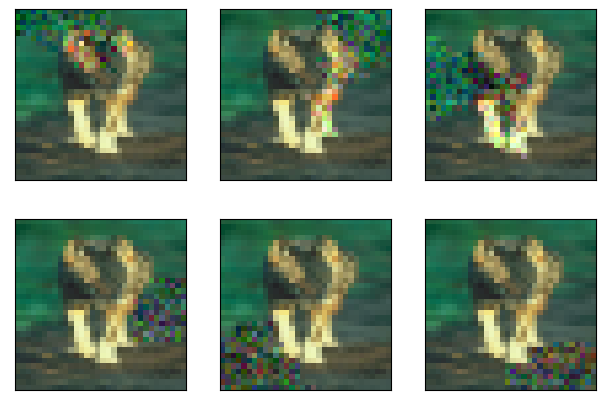

In [152]:
# Test modify_segments()
image = utils.load_image('data/cinic-10-imagenet/train/dog/n02114712_211.png')

slic_params = {
    'n_segments': 10,
}
segments = segment(
    image,
    method='slic',
    params=slic_params)

visualizations.show_image(image)
visualizations.show_image(segments)
# modified_images = modify_segments(
#     image=image,
#     segments=segments,
#     method='mask')
modified_images = modify_segments(
    image=image,
    segments=segments,
    method='gaussian_noise')

modified_images = visualizations.make_grid(modified_images, items_per_row=3)
visualizations.show_image_rows(modified_images)

(32, 32)
[0 1 2 3 4 5]


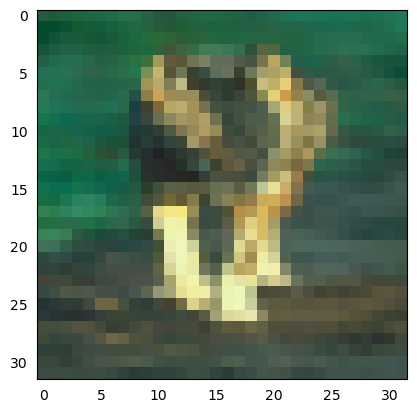

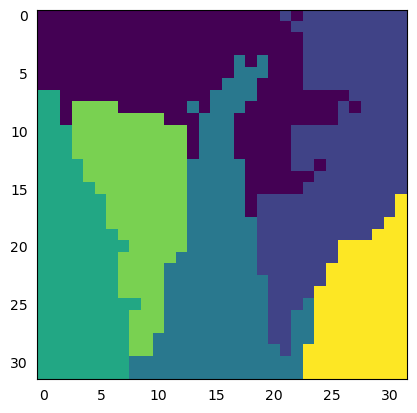

<function print>

In [147]:
print(labels.shape)
# print(type(*labels.shape))
print(np.unique(labels))
# visualizations.show_image_rows(
#     images=[[image, labels]]
# )
visualizations.show_image(image)
visualizations.show_image(labels)
print

# Scale Up to 10 images

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


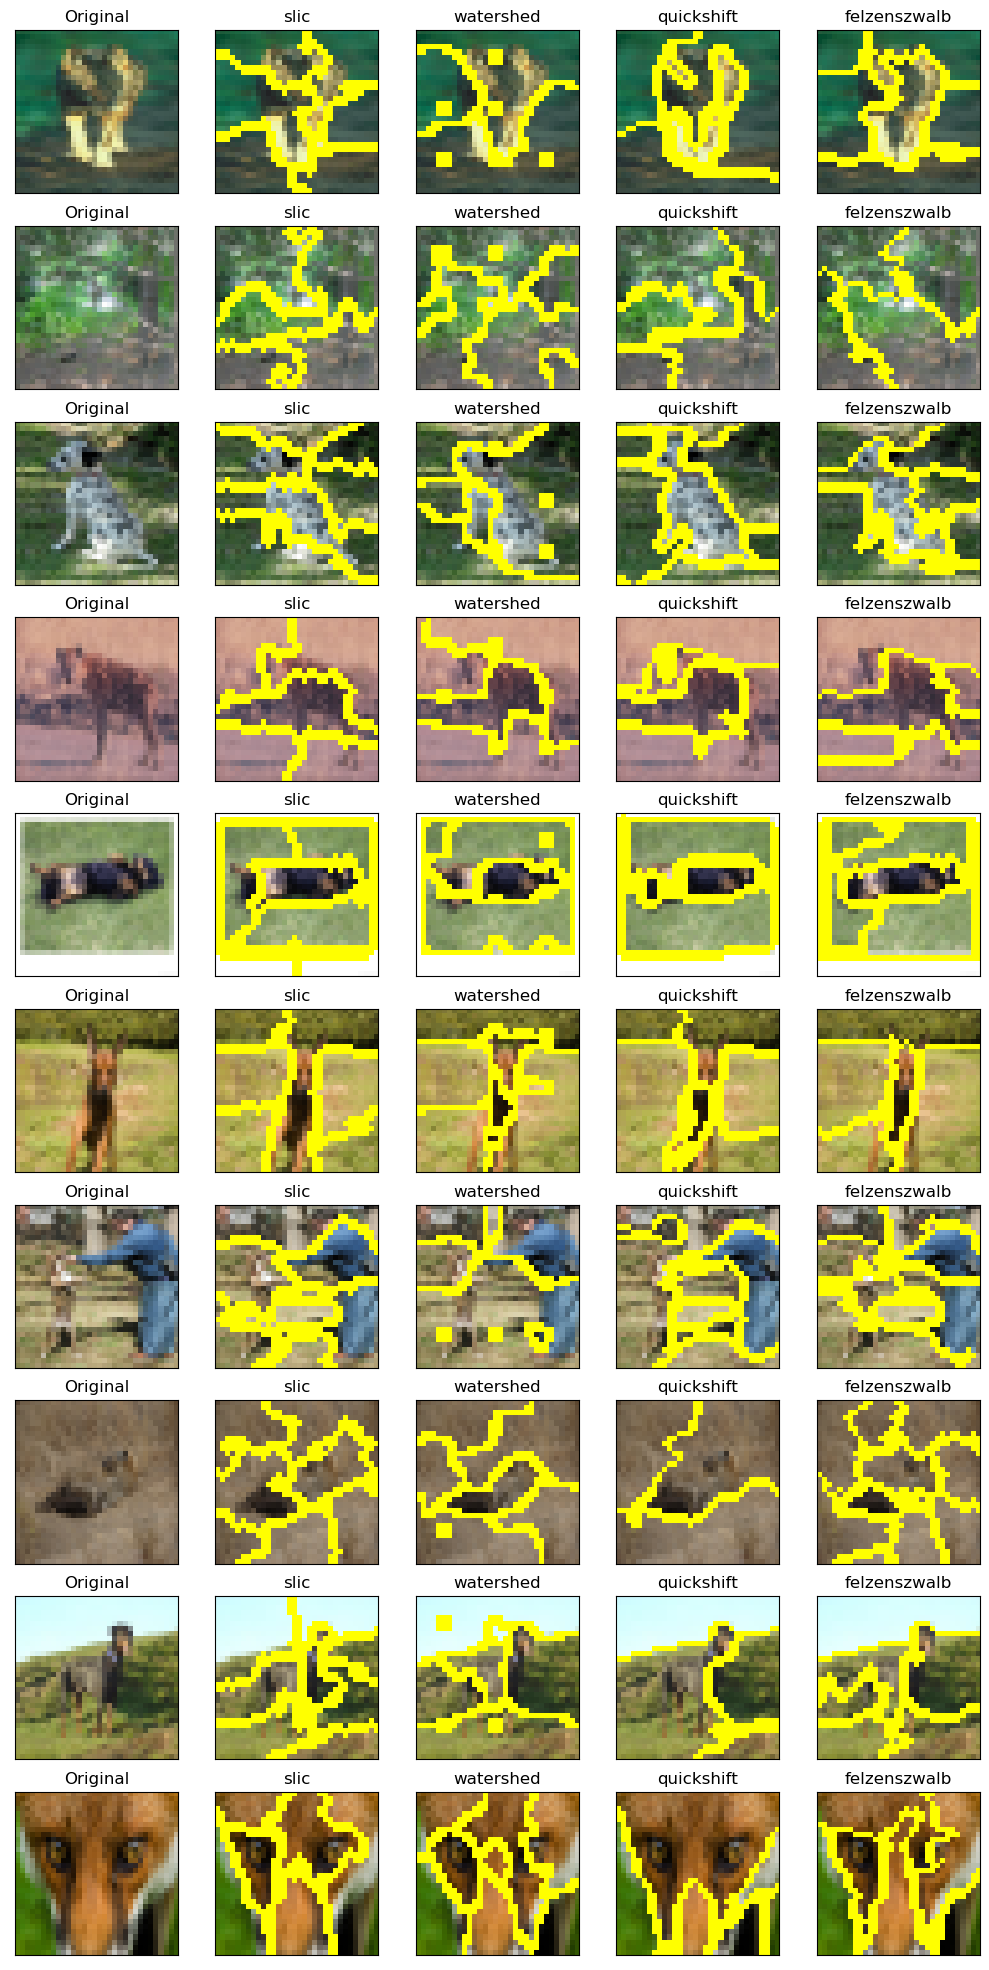

In [119]:
image_paths_path = os.path.join('paths', 'edits', 'dog', 'keys', 'key_image_paths.txt')
image_paths = utils.read_lists(image_paths_path)

felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    # 'channel_axis': 0,
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
    # 'channel_axis': 0
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Create list of methods and corresponding parameters
methods = []
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))
# methods.append(('quickshift', {}))
methods.append(('quickshift', quickshift_params))
# methods.append(('felzenszwalb', {}))
methods.append(('felzenszwalb', felzenszwalb_params))
n_methods = len(methods)

images = []
titles = []

for path in image_paths:
    image = utils.load_image(path)
    images.append(image)
    titles.append('Original')
    for method, method_params in methods:
        labels = segment(
            image,
            method=method,
            params=method_params)

        annotated_image = segmentation.mark_boundaries(np.transpose(image, axes=[1, 2, 0]), labels)
        images.append(annotated_image)
        titles.append(method)

print(type(images[0]))
images = visualizations.make_grid(images, items_per_row=n_methods+1)
titles = visualizations.make_grid(titles, items_per_row=n_methods+1)
print(type(images))
print(type(images[0]))
print(type(images[0][0]))
visualizations.show_image_rows(
    images,
    image_titles=titles)
    # save_path='visualizations/segmentation_comparison.png')